# Walmart Sales Forecasting

**Goal:** The objective of this project is to build a machine learning model that accurately forecasts weekly sales for various departments within different Walmart stores.

**Approach:** Using a time series forecasting approach with a machine learning model. This involves:
* **Feature Engineering:** Creating time-based features like lags and rolling averages from historical data.
* **Modeling:** Training and comparing different regression models to predict future sales.
* **Forecasting:** Using best model to generate a sales forecast for 12 weeks into the future.

## 1. Setup: Importing Libraries and Loading Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose

## 2. Data Merging, Cleaning, and Initial Exploration
### 2.1 Loading and exploring files

In [2]:
# load data
train_df = pd.read_csv("train.csv", parse_dates=["Date"])
features_df = pd.read_csv("features.csv", parse_dates=["Date"])
stores_df = pd.read_csv("stores.csv")

* **Train DF:**

In [3]:
print(train_df.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False


* **Features DF:**

In [4]:
print(features_df.head())

   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN  211.350143         8.106      False  


* **Stores DF:**

In [5]:
print(stores_df.head())

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


### 2.2 Data Merging and sorting

In [6]:
df = train_df.merge(features_df, on=["Store", "Date"], how="left").merge(stores_df, on="Store", how="left")
df = df.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)
df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False,B,118221


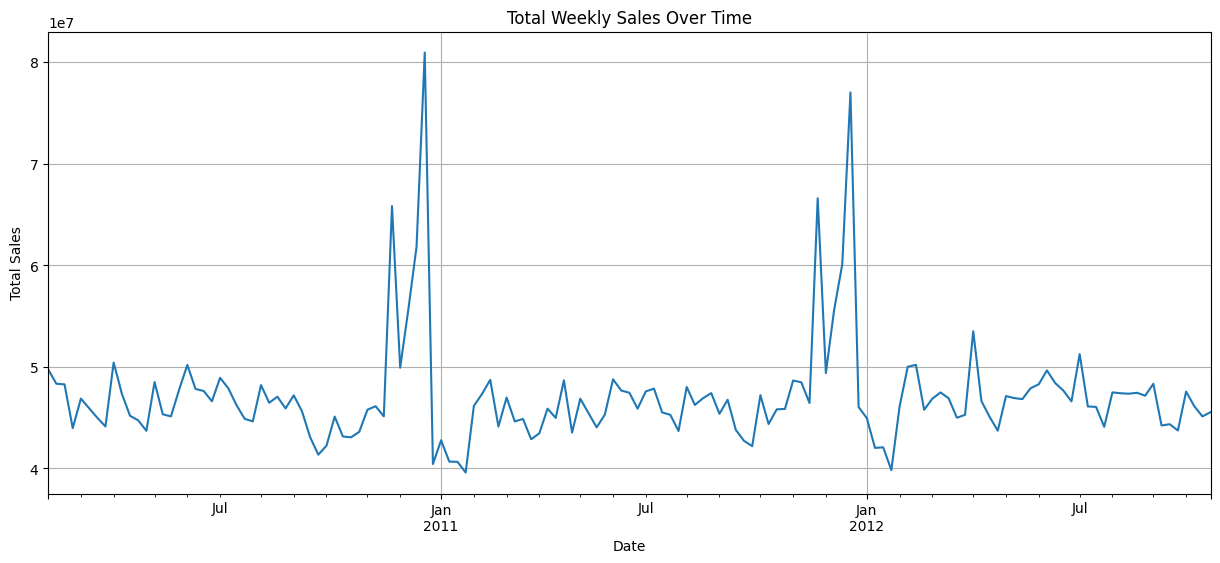

In [7]:
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum()
plt.figure(figsize=(15, 6))
weekly_sales.plot()
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [8]:
if (df['IsHoliday_x'] == df['IsHoliday_y']).all() :
    df = df.drop(columns=['IsHoliday_y'])
    df = df.rename(columns={'IsHoliday_x': 'IsHoliday'})
df    

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


### Handling missing values in ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'] columns

In [9]:
for col in ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']:
    df[col] = df[col].fillna(0)   

## 3. Feature Engineering: Building Predictive Signals

* **Date-Based Features:** We extract components like `Year`, `Month`, and `WeekOfYear` directly from the date.

In [10]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["week_of_year"] = df["Date"].dt.isocalendar().week.astype(int)
df["is_Holiday"] = df["IsHoliday"].astype(int)
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,week_of_year,is_Holiday
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,A,151315,2010,2,5,0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,A,151315,2010,2,6,1
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315,2010,2,7,0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,A,151315,2010,2,8,0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,A,151315,2010,3,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,2012,9,39,0
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,B,118221,2012,10,40,0
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,B,118221,2012,10,41,0
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,B,118221,2012,10,42,0


* **Lag Features:** We create features that represent the sales from previous weeks (e.g., `lag_1` is sales from one week ago). This gives the model "memory" of recent performance.

In [11]:
for L in range(1,8):
    df[f"lag_{L}"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(L)
df    

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Month,week_of_year,is_Holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,...,2,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,...,2,6,1,24924.50,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,...,2,7,0,46039.49,24924.50,NaN,NaN,NaN,NaN,NaN
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,...,2,8,0,41595.55,46039.49,24924.50,NaN,NaN,NaN,NaN
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,...,3,9,0,19403.54,41595.55,46039.49,24924.50,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,...,9,39,0,467.30,605.96,352.44,346.04,415.40,500.16,727.49
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,...,10,40,0,508.37,467.30,605.96,352.44,346.04,415.40,500.16
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,...,10,41,0,628.10,508.37,467.30,605.96,352.44,346.04,415.40
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,...,10,42,0,1061.02,628.10,508.37,467.30,605.96,352.44,346.04


* **Rolling Average Features:** We calculate the average sales over a specific window (e.g., `rmean_4w` is the average of the last 4 weeks). This helps the model understand the recent trend and smooths out noise.

In [12]:
df["rmean_4w"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(window=4, min_periods=1).mean().reset_index(drop=True)
df["rmean_13w"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(window=13, min_periods=1).mean().reset_index(drop=True)
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,is_Holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rmean_4w,rmean_13w
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,...,1,24924.50,NaN,NaN,NaN,NaN,NaN,NaN,24924.500000,24924.500000
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,...,0,46039.49,24924.50,NaN,NaN,NaN,NaN,NaN,35481.995000,35481.995000
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,...,0,41595.55,46039.49,24924.50,NaN,NaN,NaN,NaN,37519.846667,37519.846667
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,...,0,19403.54,41595.55,46039.49,24924.50,NaN,NaN,NaN,32990.770000,32990.770000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,...,0,467.30,605.96,352.44,346.04,415.40,500.16,727.49,442.935000,575.350769
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,...,0,508.37,467.30,605.96,352.44,346.04,415.40,500.16,483.517500,561.339231
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,...,0,628.10,508.37,467.30,605.96,352.44,346.04,415.40,552.432500,558.912308
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,...,0,1061.02,628.10,508.37,467.30,605.96,352.44,346.04,666.197500,587.051538


## 4. Final Data Preparation for Modeling

1.  **Drop Missing Values:** The lag and rolling average features created `NaN` values at the beginning of the time series for each item. We remove these rows as the model cannot train on them.

In [13]:
df_model = df.dropna(subset=[f"lag_{L}" for L in range(1, 8)] + ["rmean_4w"]).copy()
df_model

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,is_Holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rmean_4w,rmean_13w
7,1,1,2010-03-26,26229.21,False,51.45,2.732,0.00,0.00,0.00,...,0,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50,21102.8675,28138.715714
8,1,1,2010-04-02,57258.43,False,62.27,2.719,0.00,0.00,0.00,...,0,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,22809.2850,27900.027500
9,1,1,2010-04-09,42960.91,False,65.86,2.770,0.00,0.00,0.00,...,0,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,31666.9175,31162.072222
10,1,1,2010-04-16,17596.96,False,66.32,2.808,0.00,0.00,0.00,...,0,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,37146.2975,32341.956000
11,1,1,2010-04-23,16145.35,False,64.84,2.795,0.00,0.00,0.00,...,0,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,36011.3775,31001.501818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,...,0,467.30,605.96,352.44,346.04,415.40,500.16,727.49,442.9350,575.350769
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,...,0,508.37,467.30,605.96,352.44,346.04,415.40,500.16,483.5175,561.339231
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,...,0,628.10,508.37,467.30,605.96,352.44,346.04,415.40,552.4325,558.912308
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,...,0,1061.02,628.10,508.37,467.30,605.96,352.44,346.04,666.1975,587.051538


2.  **One-Hot Encoding:** We convert categorical features like `Month` and store `Type` into a numerical format using `pd.get_dummies`. This allows the model to understand these features without assuming a false numerical order.

In [14]:
df_model = pd.get_dummies(df_model, columns=["Month"], prefix="M", drop_first=True)
df_model = pd.get_dummies(df_model, columns=['Type'], drop_first=True)
df_model

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12,Type_B,Type_C
7,1,1,2010-03-26,26229.21,False,51.45,2.732,0.00,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
8,1,1,2010-04-02,57258.43,False,62.27,2.719,0.00,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
9,1,1,2010-04-09,42960.91,False,65.86,2.770,0.00,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
10,1,1,2010-04-16,17596.96,False,66.32,2.808,0.00,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
11,1,1,2010-04-23,16145.35,False,64.84,2.795,0.00,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,...,False,False,False,False,True,False,False,False,True,False
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,...,False,False,False,False,False,True,False,False,True,False
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,...,False,False,False,False,False,True,False,False,True,False
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,...,False,False,False,False,False,True,False,False,True,False


## 5. Splitting the Data for Time Series

We perform a **time-based split** to simulate a real-world scenario:
* **Training Set:** The first 70% of the data (the distant past).
* **Validation Set:** The next 15% of the data (the recent past, used for model tuning).
* **Test Set:** The final 15% of the data (the "future," used for final evaluation).


In [15]:
dates = df_model["Date"].sort_values().unique()
n = len(dates)
train_end = dates[int(0.7*n)]
val_end = dates[int(0.85*n)]

train_df = df_model[df_model["Date"] <= train_end]
val_df = df_model[(df_model["Date"] > train_end) & (df_model["Date"] <= val_end)]
test_df = df_model[df_model["Date"] > val_end]

features = [c for c in df_model.columns if c not in ['Weekly_Sales','Date','IsHoliday','Store','Dept']]

In [16]:
X_train, Y_train = train_df[features], train_df["Weekly_Sales"]
X_val, Y_val = val_df[features], val_df["Weekly_Sales"]
X_test, Y_test = test_df[features], test_df["Weekly_Sales"]

## 6. Model Training and Selection

1.  **Ridge Regression:** A simple, fast linear model that serves as a good baseline. It requires **feature scaling**, so we use `StandardScaler`.
2.  **LightGBM:** A powerful and fast gradient boosting model that is often state-of-the-art for tabular data.

We train both models on the `train` set and evaluate their performance on the `validation` set using Mean Absolute Error (MAE). The model with the lower MAE is selected as the winner.


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Ridge model
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train_scaled, Y_train)

# Evaluate
predictions_ridge = ridge_model.predict(X_val_scaled)
mae_ridge = mean_absolute_error(Y_val, predictions_ridge)

print(f"Ridge Validation MAE: ${mae_ridge:,.2f}")

Ridge Validation MAE: $2,115.82


In [18]:
# LightGBM model
lgbm_model = lgb.LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, Y_train)

# 2. Evaluate on the validation set
predictions_lgbm = lgbm_model.predict(X_val)
mae_lgbm = mean_absolute_error(Y_val, predictions_lgbm)

print(f"LightGBM Validation MAE: ${mae_lgbm:,.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4647
[LightGBM] [Info] Number of data points in the train set: 280492, number of used features: 35
[LightGBM] [Info] Start training from score 16177.399780
LightGBM Validation MAE: $1,592.58


## 7. Final Model Evaluation

After selecting our best model (LightGBM), we perform one final evaluation on the **test set**. The resulting MAE and RMSE scores give us an honest and unbiased measure of how the model is expected to perform on new, real-world data.

In [19]:
# Make predictions
final_predictions = lgbm_model.predict(X_test)

# Calculate the final error metrics
final_mae = mean_absolute_error(Y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(Y_test, final_predictions))

print(f"Final Test MAE: ${final_mae:,.2f}")
print(f"Final Test RMSE: ${final_rmse:,.2f}")

Final Test MAE: $1,387.91
Final Test RMSE: $2,979.92


## 8. Visualizing Results and Deeper Analysis

Perform a **seasonal decomposition** on the sales of a single store. This is an analytical technique that breaks the time series down into its underlying **Trend**, **Seasonality**, and **Residual** components, helping us understand the patterns driving the sales.

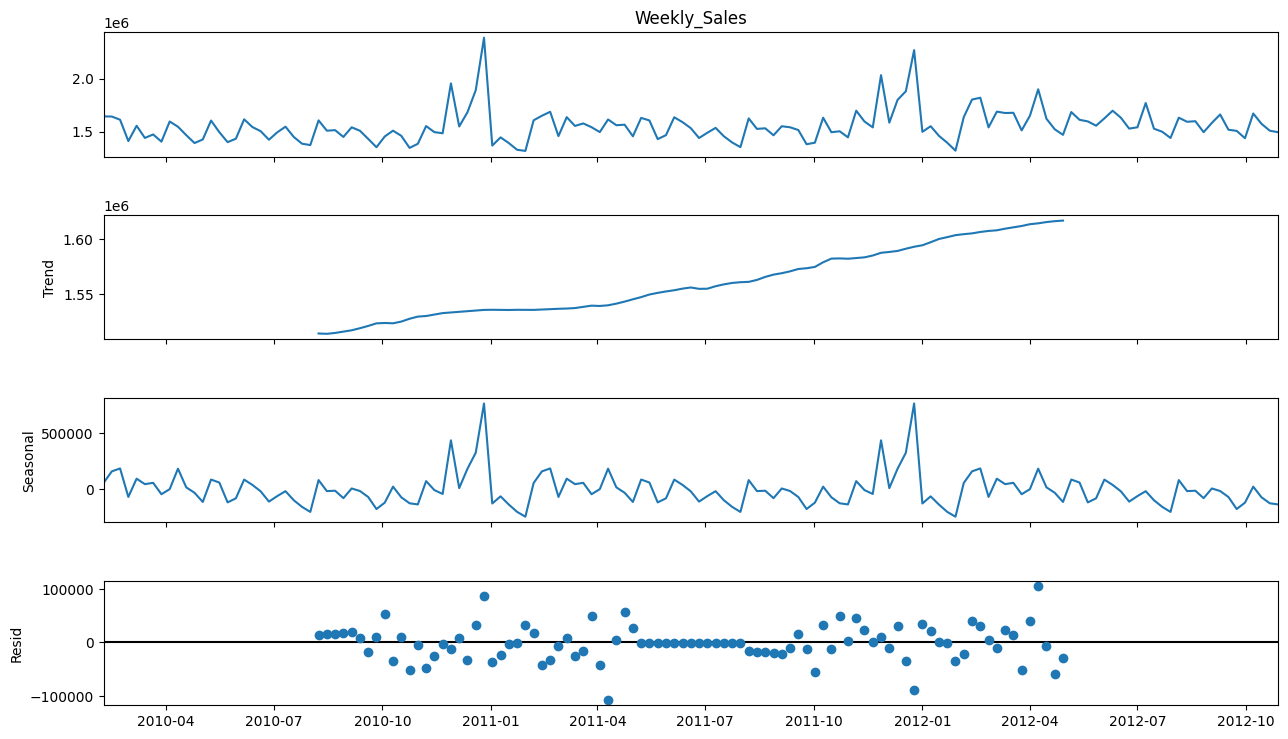

In [20]:
store1_sales = df[df['Store'] == 1].groupby('Date')['Weekly_Sales'].sum()

store1_sales = store1_sales.resample('W').sum()

result = seasonal_decompose(store1_sales, model='additive', period=52)

fig = result.plot()
fig.set_size_inches(15, 8)
plt.savefig('plots/seasonal_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

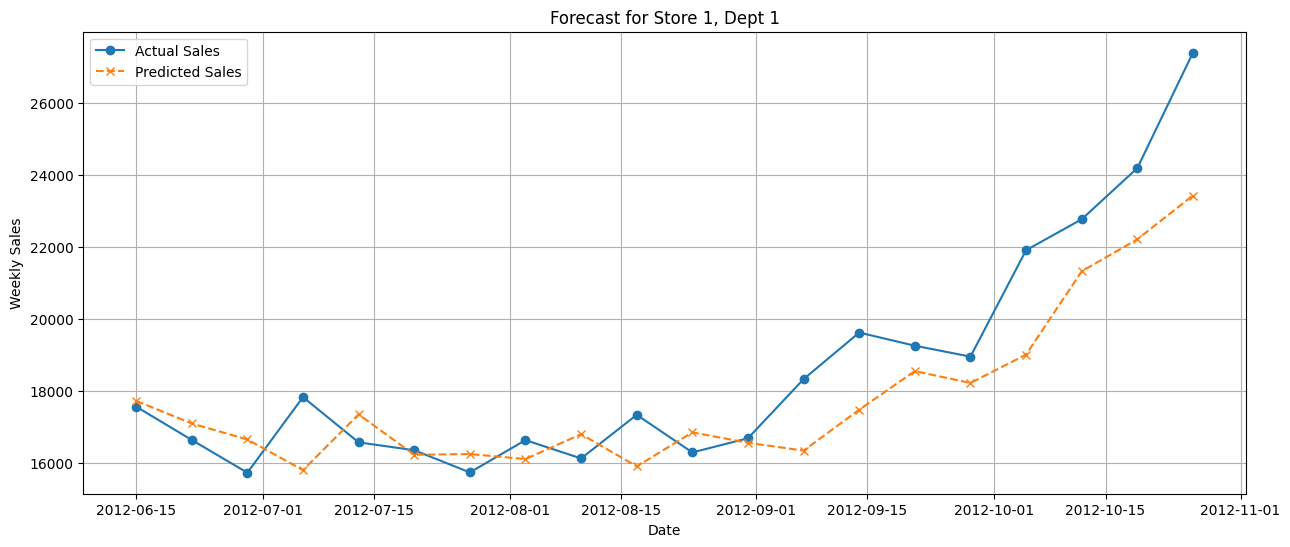

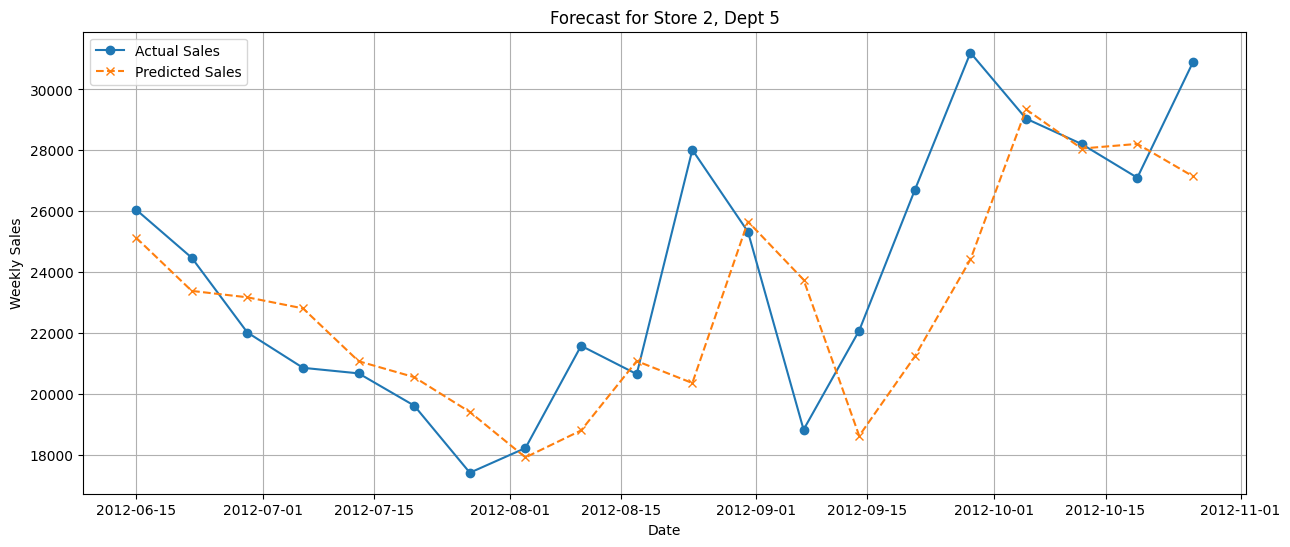

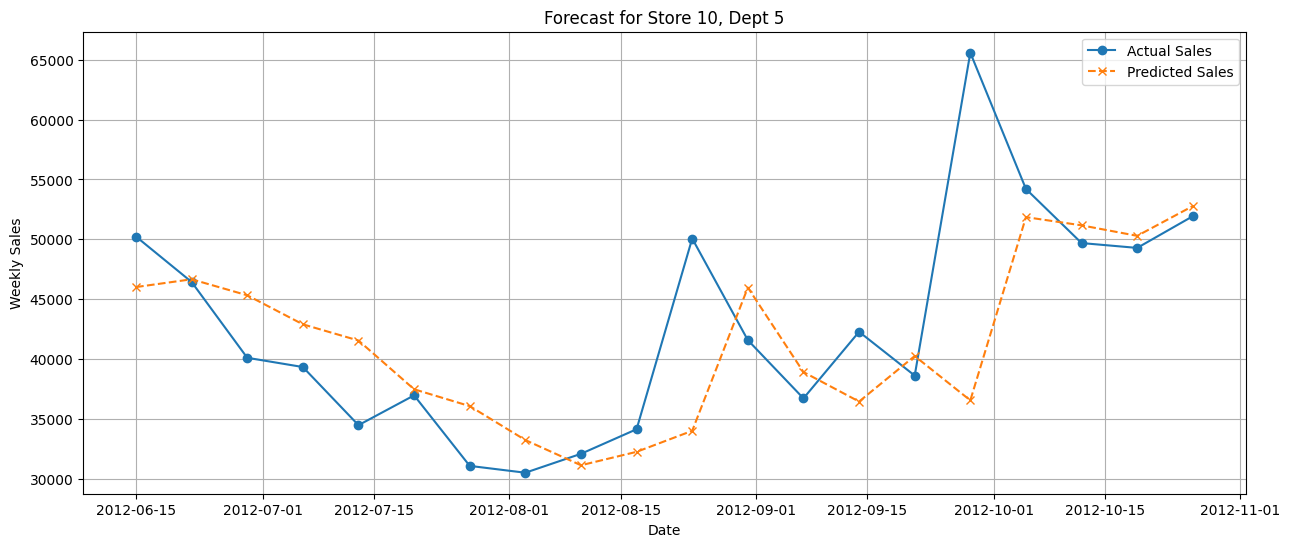

In [21]:
final_results_df = pd.DataFrame({
    'Date': test_df['Date'], 
    'Store': test_df['Store'],
    'Dept': test_df['Dept'],
    'Actual_Sales': Y_test,
    'Predicted_Sales': final_predictions
})

pairs_to_plot = [(1, 1), (2, 5), (10, 5)]

for store, dept in pairs_to_plot:
    plot_df = final_results_df[
        (final_results_df['Store'] == store) &
        (final_results_df['Dept'] == dept)
    ]

    if not plot_df.empty:
        plt.figure(figsize=(15, 6))
        plt.plot(plot_df['Date'], plot_df['Actual_Sales'], label='Actual Sales', marker='o')
        plt.plot(plot_df['Date'], plot_df['Predicted_Sales'], label='Predicted Sales', marker='x', linestyle='--')

        plt.title(f'Forecast for Store {store}, Dept {dept}')
        plt.xlabel('Date')
        plt.ylabel('Weekly Sales')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'plots/forecast_for_Store_{store},_Dept_{dept}.png', dpi=300, bbox_inches='tight')
        plt.show()

## 9. Forecasting Beyond the Dataset 

In [22]:
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=12, freq='W-FRI')
print("Forecasting for:", future_dates)

# seed history
history_df = df_model.copy()
future_predictions = []

for date in future_dates:
    print(f"Predicting {date.date()}...")

    # take last known row per Store+Dept
    last = history_df.groupby(['Store','Dept']).tail(1).copy()
    last['Date'] = date
    last['Year'] = date.year
    last['Month'] = date.month
    last['week_of_year'] = date.isocalendar().week
    last['is_Holiday'] = 0  # assume no holiday unless you map them in

    # update lag features
    for l in range(7,1,-1):
        last[f'lag_{l}'] = last[f'lag_{l-1}']
    last['lag_1'] = last['Weekly_Sales']

    # update rolling means
    last['rmean_4w'] = (last['rmean_4w']*3 + last['lag_1'])/4
    last['rmean_13w'] = (last['rmean_13w']*12 + last['lag_1'])/13

    # dummy columns check
    for m in range(2,13):
        col = f'M_{m}'
        if col not in last.columns:
            last[col] = (last['Month']==m).astype(int)

    X_future = last[features]
    preds = lgbm_model.predict(X_future)
    last['Weekly_Sales'] = preds

    history_df = pd.concat([history_df, last])
    future_predictions.append(last[['Store','Dept','Date','Weekly_Sales']])

final_forecast_df = pd.concat(future_predictions)


Forecasting for: DatetimeIndex(['2012-11-02', '2012-11-09', '2012-11-16', '2012-11-23',
               '2012-11-30', '2012-12-07', '2012-12-14', '2012-12-21',
               '2012-12-28', '2013-01-04', '2013-01-11', '2013-01-18'],
              dtype='datetime64[ns]', freq='W-FRI')
Predicting 2012-11-02...
Predicting 2012-11-09...
Predicting 2012-11-16...
Predicting 2012-11-23...
Predicting 2012-11-30...
Predicting 2012-12-07...
Predicting 2012-12-14...
Predicting 2012-12-21...
Predicting 2012-12-28...
Predicting 2013-01-04...
Predicting 2013-01-11...
Predicting 2013-01-18...


## 10. Visualizing the Future Forecast

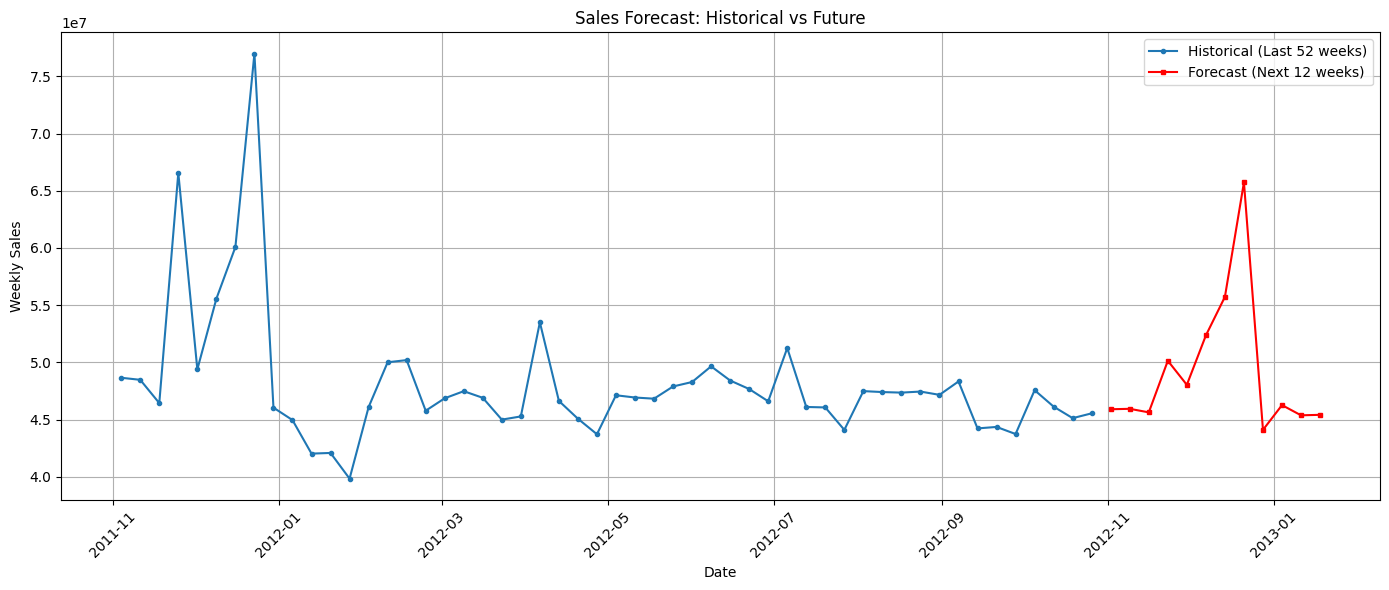

In [23]:
# Aggregate historical + forecasted sales
hist = df_model.groupby("Date")["Weekly_Sales"].sum().tail(52)   # last 52 weeks history
future_sales = final_forecast_df.groupby("Date")["Weekly_Sales"].sum()

# Plot
plt.figure(figsize=(14,6))
plt.plot(hist.index, hist.values, label="Historical (Last 52 weeks)", marker='o', markersize=3)
plt.plot(future_sales.index, future_sales.values, label="Forecast (Next 12 weeks)", marker='s', markersize=3, color='red')

plt.title("Sales Forecast: Historical vs Future")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/Sales_Forecast.png', dpi=300, bbox_inches='tight')
plt.show()